# *Imports*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from xgboost import XGBRegressor

import optuna

c:\Users\User\Documents\GitHub\wind-energy-forecast\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **1. Load and Prepare Data** 

In [2]:
df = pd.read_csv("../data/processed/agg_data_ml.csv")
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data').reset_index(drop=True) # Sort and reset index

# Features (X) and Original Target (y_orig)
X = df.drop(columns=['Data', 'Eólica'])
y_orig = df['Eólica']

# Log-transformed Target (y_log)
y_log = np.log1p(y_orig) # log1p for stability if y_orig can be 0

# --- Splitting Data (Original Target) ---
split_index = int(len(df) * 0.8)
X_train_val_orig, X_test_orig = X.iloc[:split_index], X.iloc[split_index:]
y_train_val_orig, y_test_orig = y_orig.iloc[:split_index], y_orig.iloc[split_index:]

# --- Splitting Data (Log-Transformed Target) ---
# X features remain the same
y_train_val_log, y_test_log = y_log.iloc[:split_index], y_log.iloc[split_index:]

# Create copies for testing (original scale)
X_test = X_test_orig.copy()
y_test = y_test_orig.copy() # This is the ultimate truth for evaluation

## *Scaling (Required for ANN)*


In [3]:
# --- Scaling for Original Target ANN ---
scaler_X_orig = MinMaxScaler()
scaler_y_orig = MinMaxScaler()

X_train_val_scaled_orig = scaler_X_orig.fit_transform(X_train_val_orig)
y_train_val_scaled_orig = scaler_y_orig.fit_transform(y_train_val_orig.values.reshape(-1, 1))

X_test_scaled_orig = scaler_X_orig.transform(X_test_orig)

X_train_ann_orig, X_val_ann_orig, y_train_ann_orig, y_val_ann_orig = train_test_split(
    X_train_val_scaled_orig, y_train_val_scaled_orig, test_size=0.15, random_state=42, shuffle=False # Time series data, no shuffle for split
)

# --- Scaling for Log-Transformed Target ANN ---
scaler_X_log = MinMaxScaler() # Can reuse scaler_X_orig if fitted on the same X data
scaler_y_log = MinMaxScaler()

X_train_val_scaled_log = scaler_X_log.fit_transform(X_train_val_orig) # X_train_val_orig is the same feature set
y_train_val_scaled_log = scaler_y_log.fit_transform(y_train_val_log.values.reshape(-1, 1))

X_test_scaled_log = scaler_X_log.transform(X_test_orig)

X_train_ann_log, X_val_ann_log, y_train_ann_log, y_val_ann_log = train_test_split(
    X_train_val_scaled_log, y_train_val_scaled_log, test_size=0.15, random_state=42, shuffle=False # Time series data, no shuffle for split
)

# **2. Original Target Variable Modeling**

## **2.1 Initial Model Training & Evaluation (Original Target)**

In [4]:
predictions_orig = {}
models_trained_orig = {}

### **ExtraTrees (Original Target)**


In [5]:
et_model_orig = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1)
et_model_orig.fit(X_train_val_orig, y_train_val_orig)
predictions_orig['ExtraTrees'] = et_model_orig.predict(X_test)
models_trained_orig['ExtraTrees'] = et_model_orig

### **RandomForest (Original Target)**


In [6]:
rf_model_orig = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_model_orig.fit(X_train_val_orig, y_train_val_orig) 
predictions_orig['RandomForest'] = rf_model_orig.predict(X_test)
models_trained_orig['RandomForest'] = rf_model_orig

### **Gradient Boosting (Original Target)** 


In [7]:
gb_model_orig = GradientBoostingRegressor(n_estimators=500, random_state=42)
gb_model_orig.fit(X_train_val_orig, y_train_val_orig)
predictions_orig['GradientBoosting'] = gb_model_orig.predict(X_test)
models_trained_orig['GradientBoosting'] = gb_model_orig

### **XGBoost (Original Target)**


In [8]:
xgb_model_orig = XGBRegressor(n_estimators=500, random_state=42, verbosity=0, n_jobs=-1)
xgb_model_orig.fit(X_train_val_orig, y_train_val_orig)
predictions_orig['XGBoost'] = xgb_model_orig.predict(X_test)
models_trained_orig['XGBoost'] = xgb_model_orig

### **ANN (Original Target)**

In [9]:
ann_model_orig = Sequential([
    Input((X_train_ann_orig.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

ann_model_orig.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop_orig = EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)

In [10]:
history_orig = ann_model_orig.fit(
    X_train_ann_orig, y_train_ann_orig,
    validation_data=(X_val_ann_orig, y_val_ann_orig),
    epochs=200,     
    batch_size=32,
    callbacks=[early_stop_orig],
    verbose=1 
)

Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0987 - mae: 0.2432 - val_loss: 0.0318 - val_mae: 0.1329
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - mae: 0.1523 - val_loss: 0.0267 - val_mae: 0.1243
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - mae: 0.1327 - val_loss: 0.0246 - val_mae: 0.1199
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mae: 0.1265 - val_loss: 0.0226 - val_mae: 0.1148
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - mae: 0.1172 - val_loss: 0.0209 - val_mae: 0.1126
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mae: 0.1139 - val_loss: 0.0196 - val_mae: 0.1058
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208 - mae: 0.1113 - val_loss: 0.0171 - val_mae: 0.1002
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - mae: 0.1027 - val_loss: 0.0157 - val_mae: 0.0980
Epoch 9/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.017

In [11]:
y_pred_scaled_ann_orig = ann_model_orig.predict(X_test_scaled_orig, verbose=0)
predictions_orig['ANN'] = scaler_y_orig.inverse_transform(y_pred_scaled_ann_orig).flatten()
models_trained_orig['ANN'] = ann_model_orig

### *Initial Results (Original Target)*


--- Comparison DataFrame (Original Target - First 5 rows) ---
      Eolica_Real  Eolica_Pred_ExtraTrees  Eolica_Pred_RandomForest  \
3213     123195.1             105059.2682               107394.5250   
3214     155748.0             107566.5046               110247.9060   
3215     183423.7             199286.4184               198551.1818   
3216     178352.1             180638.6324               181293.2120   
3217      60869.3              75162.5282                71609.7096   

      Eolica_Pred_GradientBoosting  Eolica_Pred_XGBoost  Eolica_Pred_ANN  
3213                 107977.404967        127094.031250    114086.929688  
3214                 103317.032423        106265.882812     91697.882812  
3215                 209854.759963        187479.125000    188913.875000  
3216                 192626.102925        181992.562500    184389.296875  
3217                  64104.740041         70001.429688     71071.921875  

--- Evaluation Metrics (Original Target - Initial Models) -

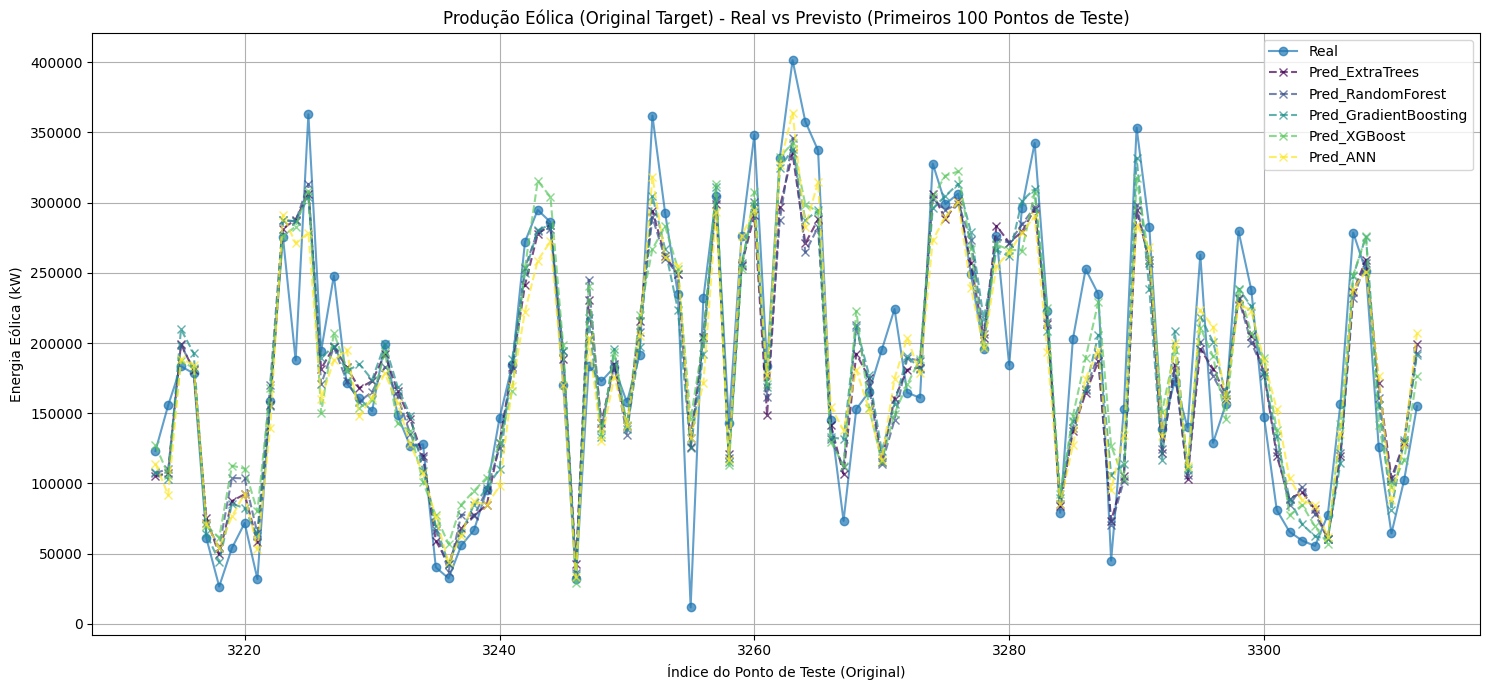

In [12]:
comparison_df_orig = pd.DataFrame({'Eolica_Real': y_test.values}, index=y_test.index)
for model_name, preds in predictions_orig.items():
    comparison_df_orig[f'Eolica_Pred_{model_name}'] = pd.Series(preds, index=y_test.index)

print("\n--- Comparison DataFrame (Original Target - First 5 rows) ---")
print(comparison_df_orig.head())

metrics_orig_initial = {}
for model_name, preds in predictions_orig.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    y_test_safe = y_test.copy()
    y_test_safe[y_test_safe == 0] = 1e-6
    mape = mean_absolute_percentage_error(y_test_safe, preds) * 100
    metrics_orig_initial[model_name] = {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

metrics_df_orig_initial = pd.DataFrame(metrics_orig_initial).T
print("\n--- Evaluation Metrics (Original Target - Initial Models) ---")
print(metrics_df_orig_initial)

plt.figure(figsize=(15, 7))
plt.plot(comparison_df_orig.index[:100], comparison_df_orig['Eolica_Real'][:100], label='Real', marker='o', linestyle='-', alpha=0.7)
colors = plt.cm.viridis(np.linspace(0, 1, len(predictions_orig)))
for i, (model_name, preds) in enumerate(predictions_orig.items()):
    plt.plot(comparison_df_orig.index[:100], comparison_df_orig[f'Eolica_Pred_{model_name}'][:100],
             label=f'Pred_{model_name}', marker='x', linestyle='--', alpha=0.7, color=colors[i])
plt.title('Produção Eólica (Original Target) - Real vs Previsto (Primeiros 100 Pontos de Teste)')
plt.xlabel('Índice do Ponto de Teste (Original)')
plt.ylabel('Energia Eólica (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **2.2 Hyperparameter Tuning (Original Target)**

### **Gradient Boosting Tuning w/ RandomizedSearchCV (Original Target)**

In [13]:
param_dist_gb_orig = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}
gb_orig = GradientBoostingRegressor(random_state=42)
tscv_orig = TimeSeriesSplit(n_splits=5)
n_iter_search_gb_orig = 30
random_search_gb_orig = RandomizedSearchCV(
    gb_orig,
    param_distributions=param_dist_gb_orig,
    n_iter=n_iter_search_gb_orig,
    cv=tscv_orig,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=0 # Silenced
)
print("A executar RandomizedSearch para Gradient Boosting (Original Target)...")
random_search_gb_orig.fit(X_train_val_orig, y_train_val_orig)
print("\nMelhores Hiperparâmetros para Gradient Boosting (Original Target):")
print(random_search_gb_orig.best_params_)

best_gb_model_orig = GradientBoostingRegressor(**random_search_gb_orig.best_params_, random_state=42)
best_gb_model_orig.fit(X_train_val_orig, y_train_val_orig)
y_pred_gb_tuned_orig = best_gb_model_orig.predict(X_test)

predictions_orig['GradientBoosting_Tuned'] = y_pred_gb_tuned_orig
models_trained_orig['GradientBoosting_Tuned'] = best_gb_model_orig

r2_gb_tuned_orig = r2_score(y_test, y_pred_gb_tuned_orig)
mae_gb_tuned_orig = mean_absolute_error(y_test, y_pred_gb_tuned_orig)
rmse_gb_tuned_orig = np.sqrt(mean_squared_error(y_test, y_pred_gb_tuned_orig))
y_test_safe_orig = y_test.copy()
y_test_safe_orig[y_test_safe_orig == 0] = 1e-6
mape_gb_tuned_orig = mean_absolute_percentage_error(y_test_safe_orig, y_pred_gb_tuned_orig) * 100
metrics_orig_initial['GradientBoosting_Tuned'] = {"R2": r2_gb_tuned_orig, "MAE": mae_gb_tuned_orig, "RMSE": rmse_gb_tuned_orig, "MAPE (%)": mape_gb_tuned_orig}
print("\nMétricas Gradient Boosting Otimizado (Original Target):")
print(f"  R2:   {r2_gb_tuned_orig:.6f}, MAE:  {mae_gb_tuned_orig:.2f}, RMSE: {rmse_gb_tuned_orig:.2f}, MAPE: {mape_gb_tuned_orig:.2f}%")

A executar RandomizedSearch para Gradient Boosting (Original Target)...

Melhores Hiperparâmetros para Gradient Boosting (Original Target):
{'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.05}

Métricas Gradient Boosting Otimizado (Original Target):
  R2:   0.897446, MAE:  23063.22, RMSE: 30082.39, MAPE: 24.62%


### **XGBoost Tuning w/ RandomizedSearchCV (Original Target)**

In [14]:
param_dist_xgb_orig = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 0.5, 1, 2]
}
xgb_orig = XGBRegressor(random_state=42, verbosity=0, objective='reg:squarederror', n_jobs=-1)
tscv_xgb_orig = TimeSeriesSplit(n_splits=5)
n_iter_search_xgb_orig = 40
random_search_xgb_orig = RandomizedSearchCV(
    xgb_orig,
    param_distributions=param_dist_xgb_orig,
    n_iter=n_iter_search_xgb_orig,
    cv=tscv_xgb_orig,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=0 # Silenced
)
print("A executar RandomizedSearch para XGBoost (Original Target)...")
random_search_xgb_orig.fit(X_train_val_orig, y_train_val_orig)
print("\nMelhores Hiperparâmetros para XGBoost (Original Target):")
print(random_search_xgb_orig.best_params_)

best_xgb_model_orig = XGBRegressor(**random_search_xgb_orig.best_params_, random_state=42, verbosity=0, objective='reg:squarederror', n_jobs=-1)
best_xgb_model_orig.fit(X_train_val_orig, y_train_val_orig)
y_pred_xgb_tuned_orig = best_xgb_model_orig.predict(X_test)

predictions_orig['XGBoost_Tuned'] = y_pred_xgb_tuned_orig
models_trained_orig['XGBoost_Tuned'] = best_xgb_model_orig

r2_xgb_tuned_orig = r2_score(y_test, y_pred_xgb_tuned_orig)
mae_xgb_tuned_orig = mean_absolute_error(y_test, y_pred_xgb_tuned_orig)
rmse_xgb_tuned_orig = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned_orig))
mape_xgb_tuned_orig = mean_absolute_percentage_error(y_test_safe_orig, y_pred_xgb_tuned_orig) * 100
metrics_orig_initial['XGBoost_Tuned'] = {"R2": r2_xgb_tuned_orig, "MAE": mae_xgb_tuned_orig, "RMSE": rmse_xgb_tuned_orig, "MAPE (%)": mape_xgb_tuned_orig}
print("\nMétricas XGBoost Otimizado (Original Target):")
print(f"  R2:   {r2_xgb_tuned_orig:.6f}, MAE:  {mae_xgb_tuned_orig:.2f}, RMSE: {rmse_xgb_tuned_orig:.2f}, MAPE: {mape_xgb_tuned_orig:.2f}%")

A executar RandomizedSearch para XGBoost (Original Target)...

Melhores Hiperparâmetros para XGBoost (Original Target):
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

Métricas XGBoost Otimizado (Original Target):
  R2:   0.894720, MAE:  23444.45, RMSE: 30479.60, MAPE: 25.34%


### **ANN Tuning w/ Optuna (Original Target)**

In [15]:
def create_ann_model_optuna_orig(trial):
    neurons1 = trial.suggest_categorical('neurons1', [32, 64, 128, 256])
    neurons2 = trial.suggest_categorical('neurons2', [16, 32, 64, 128])
    neurons3 = trial.suggest_categorical('neurons3', [8, 16, 32]) 
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.5, step=0.1)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation_func = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])

    model = Sequential([
        Input((X_train_ann_orig.shape[1],)),
        Dense(neurons1, activation=activation_func),
        Dropout(dropout_rate1),
        Dense(neurons2, activation=activation_func),
        Dropout(dropout_rate2),
        Dense(neurons3, activation=activation_func),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def objective_ann_orig(trial):
    tscv = TimeSeriesSplit(n_splits=4)
    val_maes = []
    for train_idx, val_idx in tscv.split(X_train_val_scaled_orig):
        X_train_fold, X_val_fold = X_train_val_scaled_orig[train_idx], X_train_val_scaled_orig[val_idx]
        y_train_fold, y_val_fold = y_train_val_scaled_orig[train_idx], y_train_val_scaled_orig[val_idx]
        model = create_ann_model_optuna_orig(trial)
        early_stop_optuna = EarlyStopping(monitor='val_mae', patience=30, restore_best_weights=True)
        model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=150,
            batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
            callbacks=[early_stop_optuna],
            verbose=0
        )
        loss, mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_maes.append(mae)
        trial.report(mae, step=len(val_maes))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return np.mean(val_maes)

In [16]:
study_ann_orig = optuna.create_study(direction='minimize')
print("A executar Otimização Optuna para ANN (Original Target)...")
study_ann_orig.optimize(objective_ann_orig, n_trials=5) 
print("\nMelhor Trial ANN (Original Target):")
trial_orig = study_ann_orig.best_trial
print(f"  Valor (MAE médio validação): {trial_orig.value:.6f}")
best_params_ann_orig = trial_orig.params

final_ann_model_orig = Sequential([
    Input((X_train_ann_orig.shape[1],)),
    Dense(best_params_ann_orig['neurons1'], activation=best_params_ann_orig['activation']),
    Dropout(best_params_ann_orig['dropout_rate1']),
    Dense(best_params_ann_orig['neurons2'], activation=best_params_ann_orig['activation']),
    Dropout(best_params_ann_orig['dropout_rate2']),
    Dense(best_params_ann_orig['neurons3'], activation=best_params_ann_orig['activation']),
    Dense(1, activation='linear')
])
final_optimizer_orig = Adam(learning_rate=best_params_ann_orig['learning_rate'])
final_ann_model_orig.compile(optimizer=final_optimizer_orig, loss='mean_squared_error', metrics=['mae'])

final_early_stop_orig = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, verbose=0)
print("\nA treinar modelo final ANN com melhores parâmetros (Original Target)...")
history_final_orig = final_ann_model_orig.fit(
    X_train_ann_orig, y_train_ann_orig, # Using the split made for original ANN training
    validation_data=(X_val_ann_orig, y_val_ann_orig),
    epochs=300,
    batch_size=best_params_ann_orig['batch_size'],
    callbacks=[final_early_stop_orig],
    verbose=0
)

y_pred_ann_scaled_tuned_orig = final_ann_model_orig.predict(X_test_scaled_orig, verbose=0)
y_pred_ann_tuned_orig = scaler_y_orig.inverse_transform(y_pred_ann_scaled_tuned_orig).flatten()

predictions_orig['ANN_Tuned'] = y_pred_ann_tuned_orig
models_trained_orig['ANN_Tuned'] = final_ann_model_orig

r2_ann_tuned_orig = r2_score(y_test, y_pred_ann_tuned_orig)
mae_ann_tuned_orig = mean_absolute_error(y_test, y_pred_ann_tuned_orig)
rmse_ann_tuned_orig = np.sqrt(mean_squared_error(y_test, y_pred_ann_tuned_orig))
mape_ann_tuned_orig = mean_absolute_percentage_error(y_test_safe_orig, y_pred_ann_tuned_orig) * 100
metrics_orig_initial['ANN_Tuned'] = {"R2": r2_ann_tuned_orig, "MAE": mae_ann_tuned_orig, "RMSE": rmse_ann_tuned_orig, "MAPE (%)": mape_ann_tuned_orig}

print("\nMétricas ANN Otimizada (Original Target):")
print(f"  R2:   {r2_ann_tuned_orig:.6f}, MAE:  {mae_ann_tuned_orig:.2f}, RMSE: {rmse_ann_tuned_orig:.2f}, MAPE: {mape_ann_tuned_orig:.2f}%")

metrics_df_orig_tuned = pd.DataFrame(metrics_orig_initial).T
print("\n--- Evaluation Metrics (Original Target - All Models including Tuned) ---")
print(metrics_df_orig_tuned)

[I 2025-05-07 19:19:37,722] A new study created in memory with name: no-name-3e432261-c8ea-4902-810a-ec12dd470230


A executar Otimização Optuna para ANN (Original Target)...


[I 2025-05-07 19:22:00,986] Trial 0 finished with value: 0.0524780061095953 and parameters: {'neurons1': 64, 'neurons2': 32, 'neurons3': 32, 'dropout_rate1': 0.2, 'dropout_rate2': 0.5, 'learning_rate': 0.0008633814730746033, 'activation': 'tanh', 'batch_size': 32}. Best is trial 0 with value: 0.0524780061095953.
[I 2025-05-07 19:25:38,913] Trial 1 finished with value: 0.050563338212668896 and parameters: {'neurons1': 32, 'neurons2': 16, 'neurons3': 16, 'dropout_rate1': 0.1, 'dropout_rate2': 0.1, 'learning_rate': 0.0006730685090255013, 'activation': 'tanh', 'batch_size': 16}. Best is trial 1 with value: 0.050563338212668896.
[I 2025-05-07 19:28:43,580] Trial 2 finished with value: 0.0679537607356906 and parameters: {'neurons1': 32, 'neurons2': 16, 'neurons3': 32, 'dropout_rate1': 0.1, 'dropout_rate2': 0.30000000000000004, 'learning_rate': 0.0007923592935125083, 'activation': 'relu', 'batch_size': 16}. Best is trial 1 with value: 0.050563338212668896.
[I 2025-05-07 19:31:55,852] Trial 3 


Melhor Trial ANN (Original Target):
  Valor (MAE médio validação): 0.050563

A treinar modelo final ANN com melhores parâmetros (Original Target)...

Métricas ANN Otimizada (Original Target):
  R2:   0.905206, MAE:  21794.83, RMSE: 28921.82, MAPE: 24.62%

--- Evaluation Metrics (Original Target - All Models including Tuned) ---
                              R2           MAE          RMSE   MAPE (%)
ExtraTrees              0.878253  25341.328579  32776.690536  26.931561
RandomForest            0.878134  25251.968436  32792.705030  26.868797
GradientBoosting        0.885037  24358.203776  31850.415206  26.924580
XGBoost                 0.879402  25206.869052  32621.611809  26.815399
ANN                     0.891349  23495.974592  30963.689200  24.543004
GradientBoosting_Tuned  0.897446  23063.218554  30082.385899  24.616698
XGBoost_Tuned           0.894720  23444.448393  30479.602673  25.339152
ANN_Tuned               0.905206  21794.832219  28921.818431  24.616035


# **3. Log-Transformed Target Variable Modeling**

## **3.1 Initial Model Training & Evaluation (Log Target)**

In [17]:
predictions_log = {}
models_trained_log = {}

### **ExtraTrees (Log Target)**

In [18]:
et_model_log = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1)
et_model_log.fit(X_train_val_orig, y_train_val_log) # X is original, y is log-transformed
y_pred_et_log_transformed = et_model_log.predict(X_test)
predictions_log['ExtraTrees'] = np.expm1(y_pred_et_log_transformed) # Inverse transform
models_trained_log['ExtraTrees'] = et_model_log

### **RandomForest (Log Target)**

In [19]:
rf_model_log = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_model_log.fit(X_train_val_orig, y_train_val_log) 
y_pred_rf_log_transformed = rf_model_log.predict(X_test)
predictions_log['RandomForest'] = np.expm1(y_pred_rf_log_transformed)
models_trained_log['RandomForest'] = rf_model_log

### **Gradient Boosting (Log Target)**

In [20]:
gb_model_log = GradientBoostingRegressor(n_estimators=500, random_state=42)
gb_model_log.fit(X_train_val_orig, y_train_val_log)
y_pred_gb_log_transformed = gb_model_log.predict(X_test)
predictions_log['GradientBoosting'] = np.expm1(y_pred_gb_log_transformed)
models_trained_log['GradientBoosting'] = gb_model_log

### **XGBoost (Log Target)**

In [21]:
xgb_model_log = XGBRegressor(n_estimators=500, random_state=42, verbosity=0, n_jobs=-1)
xgb_model_log.fit(X_train_val_orig, y_train_val_log)
y_pred_xgb_log_transformed = xgb_model_log.predict(X_test)
predictions_log['XGBoost'] = np.expm1(y_pred_xgb_log_transformed)
models_trained_log['XGBoost'] = xgb_model_log

### **ANN (Log Target)**

In [22]:
ann_model_log = Sequential([
    Input((X_train_ann_log.shape[1],)), # Use X_train_ann_log (scaled features)
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear') # Output is scaled log-transformed y
])

ann_model_log.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop_log = EarlyStopping(
    monitor='val_mae',
    patience=50,
    restore_best_weights=True
)

In [23]:
history_log = ann_model_log.fit(
    X_train_ann_log, y_train_ann_log, # Training on scaled features and scaled log-target
    validation_data=(X_val_ann_log, y_val_ann_log),
    epochs=200,     
    batch_size=32,
    callbacks=[early_stop_log],
    verbose=0 # Silenced
)

In [24]:
y_pred_scaled_ann_log = ann_model_log.predict(X_test_scaled_log, verbose=0)
y_pred_ann_log_transformed = scaler_y_log.inverse_transform(y_pred_scaled_ann_log).flatten() # Inverse scale to log-transformed y
predictions_log['ANN'] = np.expm1(y_pred_ann_log_transformed) # Inverse log transform to original scale
models_trained_log['ANN'] = ann_model_log

### *Initial Results (Log Target)*


--- Comparison DataFrame (Log Target - First 5 rows) ---
      Eolica_Real  Eolica_Pred_ExtraTrees  Eolica_Pred_RandomForest  \
3213     123195.1            89606.777261              93270.905373   
3214     155748.0            99941.041316             115569.820183   
3215     183423.7           194770.273031             196451.167696   
3216     178352.1           176780.045723             180035.522714   
3217      60869.3            62394.582570              54648.058582   

      Eolica_Pred_GradientBoosting  Eolica_Pred_XGBoost  Eolica_Pred_ANN  
3213                  95892.655067        121359.882812    108743.765625  
3214                  92175.501959         97835.742188     92097.640625  
3215                 186041.352012        178107.453125    171481.343750  
3216                 184836.611129        195413.546875    167075.328125  
3217                  57974.536044         45140.226562     73366.515625  

--- Evaluation Metrics (Log Target - Initial Models, evaluated o

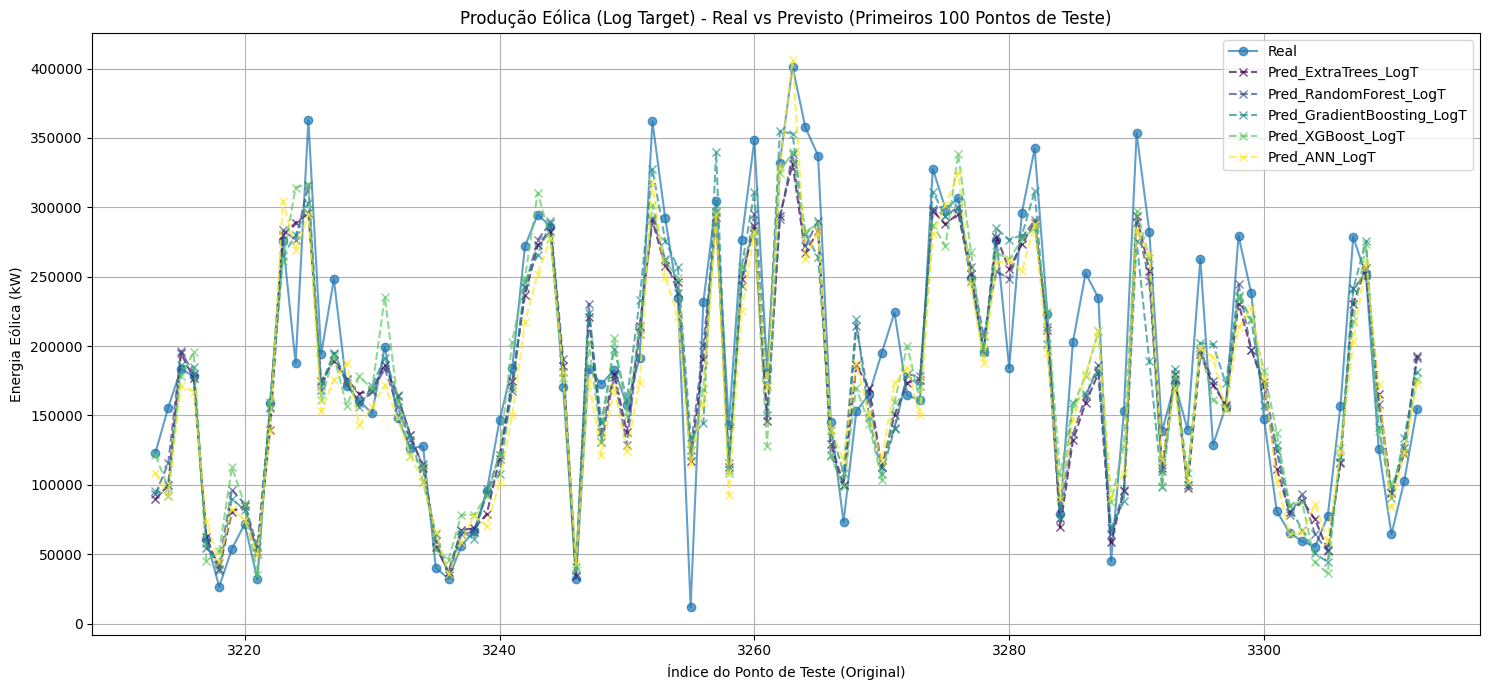

In [25]:
comparison_df_log = pd.DataFrame({'Eolica_Real': y_test.values}, index=y_test.index)
for model_name, preds in predictions_log.items():
    comparison_df_log[f'Eolica_Pred_{model_name}'] = pd.Series(preds, index=y_test.index)

print("\n--- Comparison DataFrame (Log Target - First 5 rows) ---")
print(comparison_df_log.head())

metrics_log_initial = {}
for model_name, preds in predictions_log.items():
    # Ensure predictions are positive before MAPE, handle potential NaNs/infs from expm1 if preds_log_transformed were very large/small
    preds_safe = np.nan_to_num(preds, nan=0.0, posinf=y_test.max(), neginf=0.0)
    preds_safe[preds_safe < 0] = 0 # Ensure positivity

    r2 = r2_score(y_test, preds_safe)
    mae = mean_absolute_error(y_test, preds_safe)
    rmse = np.sqrt(mean_squared_error(y_test, preds_safe))
    y_test_safe = y_test.copy()
    y_test_safe[y_test_safe == 0] = 1e-6
    mape = mean_absolute_percentage_error(y_test_safe, preds_safe) * 100
    metrics_log_initial[model_name] = {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

metrics_df_log_initial = pd.DataFrame(metrics_log_initial).T
print("\n--- Evaluation Metrics (Log Target - Initial Models, evaluated on original scale) ---")
print(metrics_df_log_initial)

plt.figure(figsize=(15, 7))
plt.plot(comparison_df_log.index[:100], comparison_df_log['Eolica_Real'][:100], label='Real', marker='o', linestyle='-', alpha=0.7)
colors = plt.cm.viridis(np.linspace(0, 1, len(predictions_log)))
for i, (model_name, preds) in enumerate(predictions_log.items()):
    plt.plot(comparison_df_log.index[:100], comparison_df_log[f'Eolica_Pred_{model_name}'][:100],
             label=f'Pred_{model_name}_LogT', marker='x', linestyle='--', alpha=0.7, color=colors[i])
plt.title('Produção Eólica (Log Target) - Real vs Previsto (Primeiros 100 Pontos de Teste)')
plt.xlabel('Índice do Ponto de Teste (Original)')
plt.ylabel('Energia Eólica (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **3.2 Hyperparameter Tuning (Log Target)**

### **Gradient Boosting Tuning w/ RandomizedSearchCV (Log Target)**

In [26]:
param_dist_gb_log = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}
gb_log = GradientBoostingRegressor(random_state=42)
tscv_log_gb = TimeSeriesSplit(n_splits=5)
n_iter_search_gb_log = 30
random_search_gb_log = RandomizedSearchCV(
    gb_log,
    param_distributions=param_dist_gb_log,
    n_iter=n_iter_search_gb_log,
    cv=tscv_log_gb,
    scoring='neg_mean_absolute_error', # MAE on log-scale
    n_jobs=-1,
    random_state=42,
    verbose=0 # Silenced
)
print("A executar RandomizedSearch para Gradient Boosting (Log Target)...")
random_search_gb_log.fit(X_train_val_orig, y_train_val_log) # Train on X_orig, y_log
print("\nMelhores Hiperparâmetros para Gradient Boosting (Log Target):")
print(random_search_gb_log.best_params_)

best_gb_model_log = GradientBoostingRegressor(**random_search_gb_log.best_params_, random_state=42)
best_gb_model_log.fit(X_train_val_orig, y_train_val_log)
y_pred_gb_log_transformed_tuned = best_gb_model_log.predict(X_test)
y_pred_gb_tuned_log = np.expm1(y_pred_gb_log_transformed_tuned)

predictions_log['GradientBoosting_Tuned'] = y_pred_gb_tuned_log
models_trained_log['GradientBoosting_Tuned'] = best_gb_model_log

r2_gb_tuned_log = r2_score(y_test, y_pred_gb_tuned_log)
mae_gb_tuned_log = mean_absolute_error(y_test, y_pred_gb_tuned_log)
rmse_gb_tuned_log = np.sqrt(mean_squared_error(y_test, y_pred_gb_tuned_log))
y_test_safe = y_test.copy()
y_test_safe[y_test_safe == 0] = 1e-6
mape_gb_tuned_log = mean_absolute_percentage_error(y_test_safe, y_pred_gb_tuned_log) * 100
metrics_log_initial['GradientBoosting_Tuned'] = {"R2": r2_gb_tuned_log, "MAE": mae_gb_tuned_log, "RMSE": rmse_gb_tuned_log, "MAPE (%)": mape_gb_tuned_log}
print("\nMétricas Gradient Boosting Otimizado (Log Target):")
print(f"  R2:   {r2_gb_tuned_log:.6f}, MAE:  {mae_gb_tuned_log:.2f}, RMSE: {rmse_gb_tuned_log:.2f}, MAPE: {mape_gb_tuned_log:.2f}%")

A executar RandomizedSearch para Gradient Boosting (Log Target)...

Melhores Hiperparâmetros para Gradient Boosting (Log Target):
{'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.05}

Métricas Gradient Boosting Otimizado (Log Target):
  R2:   0.880897, MAE:  24313.53, RMSE: 32418.87, MAPE: 23.23%


### **XGBoost Tuning w/ RandomizedSearchCV (Log Target)**

In [27]:
param_dist_xgb_log = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 0.5, 1, 2]
}
xgb_log = XGBRegressor(random_state=42, verbosity=0, objective='reg:squarederror', n_jobs=-1)
tscv_xgb_log = TimeSeriesSplit(n_splits=5)
n_iter_search_xgb_log = 40
random_search_xgb_log = RandomizedSearchCV(
    xgb_log,
    param_distributions=param_dist_xgb_log,
    n_iter=n_iter_search_xgb_log,
    cv=tscv_xgb_log,
    scoring='neg_mean_absolute_error', # MAE on log-scale
    n_jobs=-1,
    random_state=42,
    verbose=0 # Silenced
)
print("A executar RandomizedSearch para XGBoost (Log Target)...")
random_search_xgb_log.fit(X_train_val_orig, y_train_val_log)
print("\nMelhores Hiperparâmetros para XGBoost (Log Target):")
print(random_search_xgb_log.best_params_)

best_xgb_model_log = XGBRegressor(**random_search_xgb_log.best_params_, random_state=42, verbosity=0, objective='reg:squarederror', n_jobs=-1)
best_xgb_model_log.fit(X_train_val_orig, y_train_val_log)
y_pred_xgb_log_transformed_tuned = best_xgb_model_log.predict(X_test)
y_pred_xgb_tuned_log = np.expm1(y_pred_xgb_log_transformed_tuned)

predictions_log['XGBoost_Tuned'] = y_pred_xgb_tuned_log
models_trained_log['XGBoost_Tuned'] = best_xgb_model_log

r2_xgb_tuned_log = r2_score(y_test, y_pred_xgb_tuned_log)
mae_xgb_tuned_log = mean_absolute_error(y_test, y_pred_xgb_tuned_log)
rmse_xgb_tuned_log = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned_log))
mape_xgb_tuned_log = mean_absolute_percentage_error(y_test_safe, y_pred_xgb_tuned_log) * 100
metrics_log_initial['XGBoost_Tuned'] = {"R2": r2_xgb_tuned_log, "MAE": mae_xgb_tuned_log, "RMSE": rmse_xgb_tuned_log, "MAPE (%)": mape_xgb_tuned_log}
print("\nMétricas XGBoost Otimizado (Log Target):")
print(f"  R2:   {r2_xgb_tuned_log:.6f}, MAE:  {mae_xgb_tuned_log:.2f}, RMSE: {rmse_xgb_tuned_log:.2f}, MAPE: {mape_xgb_tuned_log:.2f}%")

A executar RandomizedSearch para XGBoost (Log Target)...

Melhores Hiperparâmetros para XGBoost (Log Target):
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

Métricas XGBoost Otimizado (Log Target):
  R2:   0.882473, MAE:  24216.81, RMSE: 32203.67, MAPE: 23.23%


### **ANN Tuning w/ Optuna (Log Target)**

In [28]:
def create_ann_model_optuna_log(trial):
    neurons1 = trial.suggest_categorical('neurons1', [32, 64, 128, 256])
    neurons2 = trial.suggest_categorical('neurons2', [16, 32, 64, 128])
    neurons3 = trial.suggest_categorical('neurons3', [8, 16, 32])
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.5, step=0.1)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation_func = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])

    model = Sequential([
        Input((X_train_ann_log.shape[1],)), # Use X_train_ann_log (scaled features)
        Dense(neurons1, activation=activation_func),
        Dropout(dropout_rate1),
        Dense(neurons2, activation=activation_func),
        Dropout(dropout_rate2),
        Dense(neurons3, activation=activation_func),
        Dense(1, activation='linear') # Output is scaled log-transformed y
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def objective_ann_log(trial):
    tscv = TimeSeriesSplit(n_splits=4)
    val_maes = []
    for train_idx, val_idx in tscv.split(X_train_val_scaled_log): # Use scaled log data for CV split
        X_train_fold, X_val_fold = X_train_val_scaled_log[train_idx], X_train_val_scaled_log[val_idx]
        y_train_fold, y_val_fold = y_train_val_scaled_log[train_idx], y_train_val_scaled_log[val_idx]
        model = create_ann_model_optuna_log(trial)
        early_stop_optuna = EarlyStopping(monitor='val_mae', patience=30, restore_best_weights=True)
        model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=150,
            batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
            callbacks=[early_stop_optuna],
            verbose=0
        )
        loss, mae = model.evaluate(X_val_fold, y_val_fold, verbose=0) # MAE on scaled log-scale
        val_maes.append(mae)
        trial.report(mae, step=len(val_maes))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return np.mean(val_maes)

In [29]:
study_ann_log = optuna.create_study(direction='minimize')
print("A executar Otimização Optuna para ANN (Log Target)...")
study_ann_log.optimize(objective_ann_log, n_trials=5)
print("\nMelhor Trial ANN (Log Target):")
trial_log = study_ann_log.best_trial
print(f"  Valor (MAE médio validação - scaled log): {trial_log.value:.6f}")
best_params_ann_log = trial_log.params

final_ann_model_log = Sequential([
    Input((X_train_ann_log.shape[1],)),
    Dense(best_params_ann_log['neurons1'], activation=best_params_ann_log['activation']),
    Dropout(best_params_ann_log['dropout_rate1']),
    Dense(best_params_ann_log['neurons2'], activation=best_params_ann_log['activation']),
    Dropout(best_params_ann_log['dropout_rate2']),
    Dense(best_params_ann_log['neurons3'], activation=best_params_ann_log['activation']),
    Dense(1, activation='linear')
])
final_optimizer_log = Adam(learning_rate=best_params_ann_log['learning_rate'])
final_ann_model_log.compile(optimizer=final_optimizer_log, loss='mean_squared_error', metrics=['mae'])

final_early_stop_log = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, verbose=0)
print("\nA treinar modelo final ANN com melhores parâmetros (Log Target)...")
history_final_log = final_ann_model_log.fit(
    X_train_ann_log, y_train_ann_log, # Using split made for log ANN training
    validation_data=(X_val_ann_log, y_val_ann_log),
    epochs=300,
    batch_size=best_params_ann_log['batch_size'],
    callbacks=[final_early_stop_log],
    verbose=0
)

y_pred_ann_scaled_tuned_log = final_ann_model_log.predict(X_test_scaled_log, verbose=0)
y_pred_ann_log_transformed_tuned = scaler_y_log.inverse_transform(y_pred_ann_scaled_tuned_log).flatten()
y_pred_ann_tuned_log = np.expm1(y_pred_ann_log_transformed_tuned)

predictions_log['ANN_Tuned'] = y_pred_ann_tuned_log
models_trained_log['ANN_Tuned'] = final_ann_model_log

r2_ann_tuned_log = r2_score(y_test, y_pred_ann_tuned_log)
mae_ann_tuned_log = mean_absolute_error(y_test, y_pred_ann_tuned_log)
rmse_ann_tuned_log = np.sqrt(mean_squared_error(y_test, y_pred_ann_tuned_log))
mape_ann_tuned_log = mean_absolute_percentage_error(y_test_safe, y_pred_ann_tuned_log) * 100
metrics_log_initial['ANN_Tuned'] = {"R2": r2_ann_tuned_log, "MAE": mae_ann_tuned_log, "RMSE": rmse_ann_tuned_log, "MAPE (%)": mape_ann_tuned_log}

print("\nMétricas ANN Otimizada (Log Target):")
print(f"  R2:   {r2_ann_tuned_log:.6f}, MAE:  {mae_ann_tuned_log:.2f}, RMSE: {rmse_ann_tuned_log:.2f}, MAPE: {mape_ann_tuned_log:.2f}%")

metrics_df_log_tuned = pd.DataFrame(metrics_log_initial).T
print("\n--- Evaluation Metrics (Log Target - All Models including Tuned) ---")
print(metrics_df_log_tuned)

[I 2025-05-07 19:53:05,114] A new study created in memory with name: no-name-bfdfd614-9721-4616-b88e-5aae40f36188


A executar Otimização Optuna para ANN (Log Target)...


[I 2025-05-07 19:55:12,365] Trial 0 finished with value: 0.08330481126904488 and parameters: {'neurons1': 256, 'neurons2': 32, 'neurons3': 8, 'dropout_rate1': 0.4, 'dropout_rate2': 0.2, 'learning_rate': 0.0002118971062988932, 'activation': 'relu', 'batch_size': 32}. Best is trial 0 with value: 0.08330481126904488.
[I 2025-05-07 19:57:25,658] Trial 1 finished with value: 0.04519527591764927 and parameters: {'neurons1': 128, 'neurons2': 32, 'neurons3': 16, 'dropout_rate1': 0.1, 'dropout_rate2': 0.30000000000000004, 'learning_rate': 0.003067773941758216, 'activation': 'tanh', 'batch_size': 16}. Best is trial 1 with value: 0.04519527591764927.
[I 2025-05-07 20:01:11,966] Trial 2 finished with value: 0.05052033066749573 and parameters: {'neurons1': 128, 'neurons2': 64, 'neurons3': 8, 'dropout_rate1': 0.5, 'dropout_rate2': 0.4, 'learning_rate': 0.00033581641497237006, 'activation': 'tanh', 'batch_size': 16}. Best is trial 1 with value: 0.04519527591764927.
[I 2025-05-07 20:02:17,596] Trial 3


Melhor Trial ANN (Log Target):
  Valor (MAE médio validação - scaled log): 0.045195

A treinar modelo final ANN com melhores parâmetros (Log Target)...

Métricas ANN Otimizada (Log Target):
  R2:   0.869923, MAE:  25348.97, RMSE: 33879.46, MAPE: 26.24%

--- Evaluation Metrics (Log Target - All Models including Tuned) ---
                              R2           MAE          RMSE   MAPE (%)
ExtraTrees              0.867443  25966.800117  34200.823059  24.057607
RandomForest            0.872647  25748.073961  33522.758336  24.673756
GradientBoosting        0.876751  24415.607670  32978.181187  23.448612
XGBoost                 0.862003  25892.705521  34895.599402  24.935057
ANN                     0.762461  27440.362611  45782.884929  25.773891
GradientBoosting_Tuned  0.880897  24313.527457  32418.868127  23.225768
XGBoost_Tuned           0.882473  24216.812095  32203.665771  23.225555
ANN_Tuned               0.869923  25348.968025  33879.461386  26.240974


# **4. Final Comparison of Results**

--- Evaluation Metrics (Original Target - Initial Models) ---
                        R2           MAE          RMSE   MAPE (%)
ExtraTrees        0.878253  25341.328579  32776.690536  26.931561
RandomForest      0.878134  25251.968436  32792.705030  26.868797
GradientBoosting  0.885037  24358.203776  31850.415206  26.924580
XGBoost           0.879402  25206.869052  32621.611809  26.815399
ANN               0.891349  23495.974592  30963.689200  24.543004

--- Evaluation Metrics (Original Target - All Models including Tuned) ---
                              R2           MAE          RMSE   MAPE (%)
ExtraTrees              0.878253  25341.328579  32776.690536  26.931561
RandomForest            0.878134  25251.968436  32792.705030  26.868797
GradientBoosting        0.885037  24358.203776  31850.415206  26.924580
XGBoost                 0.879402  25206.869052  32621.611809  26.815399
ANN                     0.891349  23495.974592  30963.689200  24.543004
GradientBoosting_Tuned  0.897446  2

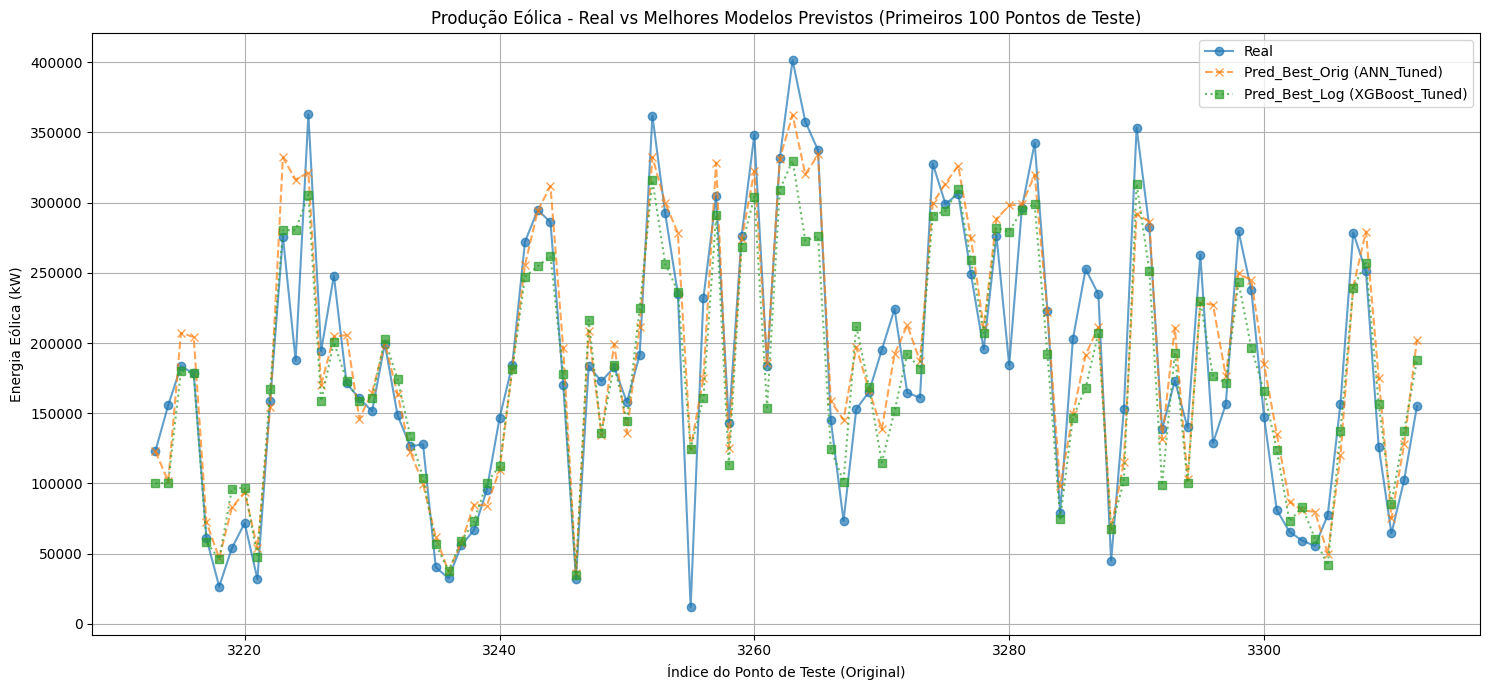


--- Resumo Consolidado das Métricas (Ordenado por MAE) ---
                     Model      Target_Type        R2           MAE  \
7                ANN_Tuned         Original  0.905206  21794.832219   
5   GradientBoosting_Tuned         Original  0.897446  23063.218554   
6            XGBoost_Tuned         Original  0.894720  23444.448393   
4                      ANN         Original  0.891349  23495.974592   
14           XGBoost_Tuned  Log-Transformed  0.882473  24216.812095   
13  GradientBoosting_Tuned  Log-Transformed  0.880897  24313.527457   
2         GradientBoosting         Original  0.885037  24358.203776   
10        GradientBoosting  Log-Transformed  0.876751  24415.607670   
3                  XGBoost         Original  0.879402  25206.869052   
1             RandomForest         Original  0.878134  25251.968436   
0               ExtraTrees         Original  0.878253  25341.328579   
15               ANN_Tuned  Log-Transformed  0.869923  25348.968025   
9             Ran

In [30]:
print("--- Evaluation Metrics (Original Target - Initial Models) ---")
print(metrics_df_orig_initial)
print("\n--- Evaluation Metrics (Original Target - All Models including Tuned) ---")
print(metrics_df_orig_tuned)

print("\n--- Evaluation Metrics (Log Target - Initial Models, evaluated on original scale) ---")
print(metrics_df_log_initial)
print("\n--- Evaluation Metrics (Log Target - All Models including Tuned, evaluated on original scale) ---")
print(metrics_df_log_tuned)

# Find best model from original target approach
best_model_name_orig = metrics_df_orig_tuned['MAE'].idxmin()
best_mae_orig = metrics_df_orig_tuned['MAE'].min()
best_preds_orig = predictions_orig[best_model_name_orig]

# Find best model from log-transformed target approach
best_model_name_log = metrics_df_log_tuned['MAE'].idxmin()
best_mae_log = metrics_df_log_tuned['MAE'].min()
best_preds_log = predictions_log[best_model_name_log]

print(f"\nBest Original Target Model: {best_model_name_orig} with MAE: {best_mae_orig:.2f}")
print(f"Best Log-Transformed Target Model: {best_model_name_log} with MAE: {best_mae_log:.2f} (on original scale)")

final_comparison_df = pd.DataFrame({
    'Eolica_Real': y_test.values,
    f'Pred_Best_Orig_{best_model_name_orig}': best_preds_orig,
    f'Pred_Best_Log_{best_model_name_log}': best_preds_log
}, index=y_test.index)

print("\n--- Final Comparison DataFrame (First 5 rows) ---")
print(final_comparison_df.head())

plt.figure(figsize=(15, 7))
plt.plot(final_comparison_df.index[:100], final_comparison_df['Eolica_Real'][:100], label='Real', marker='o', linestyle='-', alpha=0.7)
plt.plot(final_comparison_df.index[:100], final_comparison_df[f'Pred_Best_Orig_{best_model_name_orig}'][:100], 
         label=f'Pred_Best_Orig ({best_model_name_orig})', marker='x', linestyle='--', alpha=0.7)
plt.plot(final_comparison_df.index[:100], final_comparison_df[f'Pred_Best_Log_{best_model_name_log}'][:100], 
         label=f'Pred_Best_Log ({best_model_name_log})', marker='s', linestyle=':', alpha=0.7)

plt.title('Produção Eólica - Real vs Melhores Modelos Previstos (Primeiros 100 Pontos de Teste)')
plt.xlabel('Índice do Ponto de Teste (Original)')
plt.ylabel('Energia Eólica (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Consolidate all metrics for final comparison
metrics_summary = []
for model_name, metric_values in metrics_df_orig_tuned.iterrows():
    metrics_summary.append({'Model': model_name, 'Target_Type': 'Original', **metric_values})
for model_name, metric_values in metrics_df_log_tuned.iterrows():
    metrics_summary.append({'Model': model_name, 'Target_Type': 'Log-Transformed', **metric_values})

final_metrics_df = pd.DataFrame(metrics_summary)
final_metrics_df = final_metrics_df.sort_values(by='MAE')
print("\n--- Resumo Consolidado das Métricas (Ordenado por MAE) ---")
print(final_metrics_df)

# **5. Conclusion**

*(This section should be filled in after analyzing the `final_metrics_df` and the plot to discuss whether log-transformation improved results, which model performed best overall, and potential next steps.)*

Key points to compare:
- Did log-transforming the target consistently improve metrics (R2, MAE, RMSE, MAPE) for each model type?
- Which model (and with which target transformation, if any) performed best overall based on MAE or RMSE?
- How did hyperparameter tuning affect the performance for both original and log-transformed target models?
- Are the MAPE values significantly different between the two approaches?